# Shortest Path

***shortest_path*** that takes an 2D array of ***costs***, of shape HxW, as input and finds the *shortest vertical path* from top to bottom through the array. A vertical path is specified by a single horizontal location for each row of the H rows. Locations in successive rows should not differ by more than 1 so that at each step the path either goes straight or moves at most one pixel to the left or right. The cost is the sum of the costs of each entry the path traverses. This function should return an length H vector that contains the index of the path location (values in the range 0..W-1) for each of the H rows.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def find_M(M, costs):
    nrows = costs.shape[0]
    ncols = costs.shape[1]
    
    # reach the first row when calling find_M() recursively
    if nrows == 1:
        M[0] = costs[0]
        return costs[0]
    # otherwise, use M we built up before to do the computation
    else:
        temp = find_M(M, costs[:nrows-1])
        
        for i in range(ncols):
            if i == 0:
                M[nrows-1][i] = costs[nrows-1][i] + min(temp[i], temp[i+1])
            elif i == ncols-1:
                M[nrows-1][i] = costs[nrows-1][i] + min(temp[i-1], temp[i])
            else:
                M[nrows-1][i] = costs[nrows-1][i] + min(temp[i-1], temp[i], temp[i+1])
        
        # update the latest value to the next level 
        return M[nrows-1]
    
def find_path(M, row, pos, path):
    path.append(pos)

    if pos == 0:
        pos = np.argmin(M[row-1][:2])
    elif pos == len(M[row-1])-1:
        pos = np.argmin(M[row-1][len(M[row-1])-2:]) + (len(M[row-1])-2)
    else:
        pos = np.argmin(M[row-1][pos-1:pos+2]) + (pos - 1)
        
    if row == 1:
        path.append(pos)
        return
    else:    
        find_path(M, row-1, pos, path)
        
def shortest_path(costs):
    """
    This function takes an array of costs and finds a shortest path from the 
    top to the bottom of the array which minimizes the total costs along the
    path. The path should not shift more than 1 location left or right between
    successive rows.
    
    In other words, the returned path is one that minimizes the total cost:
        
        total_cost = costs[0,path[0]] + costs[1,path[1]] + costs[2,path[2]] + ...

    subject to the constraint that:
    
        abs(path[i]-path[i+1])<=1
    
    Parameters
    ----------
    costs : 2D float array of shape HxW
         An array of cost values with W>=3
    
    Returns
    -------
    path : 1D array of length H
        indices of a vertical path. path[i] contains the column index of 
        the path for each row i. 
    """
    nrows = costs.shape[0]
    ncols = costs.shape[1]
    M = np.zeros((nrows, ncols))
    find_M(M, costs)
    path = []
    find_path(M, nrows-1, np.argmin(M[nrows-1]), path)
       
    # to keep the implementation simple, we will refuse to handle
    # the boundary case where the cost array is very narrow.
    assert(ncols>=3)
    
    return path[::-1]

# Image Stitching

***stitch*** that takes two gray-scale images, ***left_image*** and ***right_image*** and a specified ***overlap*** and returns a new output image by stitching them together along a vertical seam where the two images have very similar brightness values. If the input images are of widths ***w1*** and ***w2*** then your stitched result image returned by the function should be of width ***w1+w2-overlap*** and have the same height as the two input images.

We will want to first extract the overlapping strips from the two input images and then compute a cost array given by the absolute value of their difference. We will then use ***shortest_path*** function to find the seam along which to stitch the images where they differ the least in brightness. Finally we need to generate the output image by using pixels from the left image on the left side of the seam and from the right image on the right side of the seam.

In [3]:
def stitch(left_image, right_image, overlap):
    """
    This function takes a pair of images with a specified overlap and stitches them
    togther by finding a minimal cost seam in the overlap region.
    
    Parameters
    ----------
    left_image : 2D float array of shape HxW1
        Left image to stitch 
    
    right_image : 2D float array of shape HxW2
        Right image to stitch 

    overlap : int
        Width of the overlap zone between left and right image
        
    Returns
    -------
    stitched : 2D float array of shape Hx(W1+W2-overlap)
        The resulting stitched image
    """
    
    # inputs should be the same height
    assert(left_image.shape[0]==right_image.shape[0])
    assert(overlap>=3)
    
    diff = abs(np.delete(left_image, range(left_image.shape[1]-overlap), 1) - np.delete(right_image, range(overlap, right_image.shape[1]), 1))
    path = shortest_path(diff)
    
    stitched = np.zeros((left_image.shape[0], left_image.shape[1]+right_image.shape[1]-overlap))
    
    for i, p in enumerate(path):
        stitched[i] = np.concatenate((left_image[i][:left_image.shape[1]-overlap+p], right_image[i][p:]))
    
    assert(stitched.shape[0]==left_image.shape[0])
    assert(stitched.shape[1]==(left_image.shape[1]+right_image.shape[1]-overlap))
    return stitched

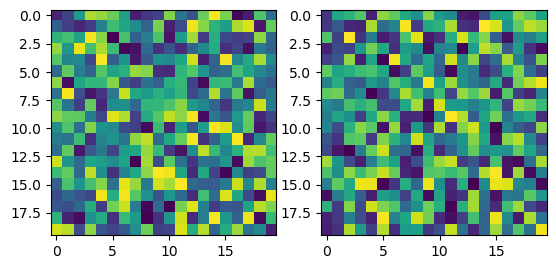

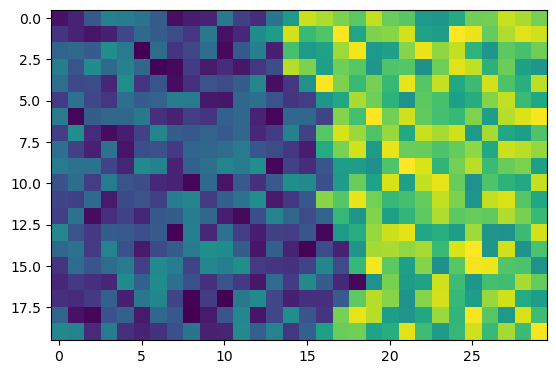

In [6]:
# a simple test visualization of stitching two random
# tiles which have different overall brightness so we
# can easily see where the seam is

L = np.random.rand(20,20)+1
R = np.random.rand(20,20)+2
fig = plt.figure()
fig.add_subplot(1,2,1).imshow(L)
fig.add_subplot(1,2,2).imshow(R)
plt.show()

S = stitch(L,R,10)
plt.imshow(S)
plt.show()

# Texture Quilting

***synth_quilt*** that takes as input an array indicating the set of texture tiles to use, an array containing the set of available texture tiles, the ***tilesize*** and ***overlap*** parameters and synthesizes the output texture by stitching together the tiles. ***synth_quilt*** should utilize stitch function repeatedly. First, for each horizontal row of tiles, construct the stitched row by successively stitching the next tile in the row on to the right side of your row image. Once we have row images for all the rows, we can stitch them together to get the final image. Since the stitch function only works for vertical seams, we will want to transpose the rows, stitch them together, and then transpose the result. 

In [7]:
def synth_quilt(tile_map,tiledb,tilesize,overlap):
  
    """
    This function takes as input an array indicating the set of texture tiles 
    to use at each location, an array containing the database of available texture 
    tiles, tilesize and overlap parameters, and synthesizes the output texture by 
    stitching together the tiles

    Parameters
    ----------
    tile_map : 2D array of int
        Array storing the indices of which tiles to paste down at each output location 
    
    tiledb : 2D array of int 
        Collection of sample tiles to select from. The array is of size ntiles x npixels 
        where each tile image is stored in vectorized form as a row of the array.
        
    tilesize : (int,int)
        Size of a tile in pixels
        
    overlap : int
        Amount of overlap between tiles
        
    Returns
    -------
    output : 2D float array
        The resulting synthesized texture of size
    """
    # determine output size based on overlap and tile size
    outh = (tilesize[0]-overlap)*tile_map.shape[0] + overlap
    outw = (tilesize[1]-overlap)*tile_map.shape[1] + overlap
    output = np.zeros((outh,outw))
    
    # The code below is a dummy implementation that pastes down each 
    # tile in the correct position in the output image. You need to 
    # replace this with your own version that stitches each row and then 
    # stitches together the colums
    row_left = None
    row_right = None
    left = None
    right = None
    
    for i in range(tile_map.shape[0]):
        for j in range(tile_map.shape[1]):             
            icoord = i*(tilesize[0]-overlap)
            jcoord = j*(tilesize[1]-overlap)
            
            if j == 0:
                tile_vec = tiledb[tile_map[i,j],:];
                left = np.reshape(tile_vec,tilesize)
            else:
                right_tile_vec = tiledb[tile_map[i,j],:];
                right = np.reshape(right_tile_vec,tilesize)
                left = stitch(left, right, overlap)
        if i == 0:
            row_left = np.transpose(left)
        else:
            row_right = np.transpose(left)
            row_left = stitch(row_left, row_right, overlap)
    output = np.transpose(row_left)
    
    return output

# Result 1

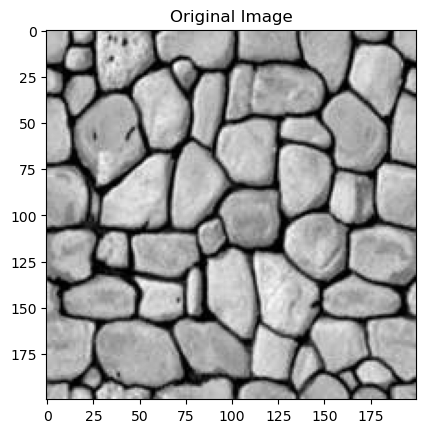

library has ntiles =  29241 each with npix =  900
row:
0
1
2
3
4
5
6
7
8
9


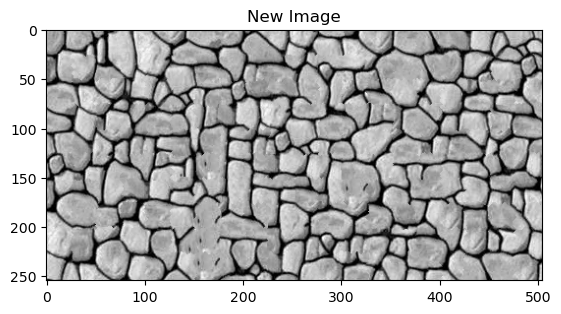

In [13]:
img = plt.imread("rock_wall.jpg")
temp_img = (img[:,:,0]*0.299 + img[:,:,1]*0.587 + img[:,:,2]*0.114)
img = temp_img

plt.imshow(img, cmap = plt.cm.gray)
plt.title("Original Image")
plt.show()

output = quilt_demo(img)
plt.imshow(output, cmap = plt.cm.gray)
plt.title("New Image")
plt.show()

# Result 2

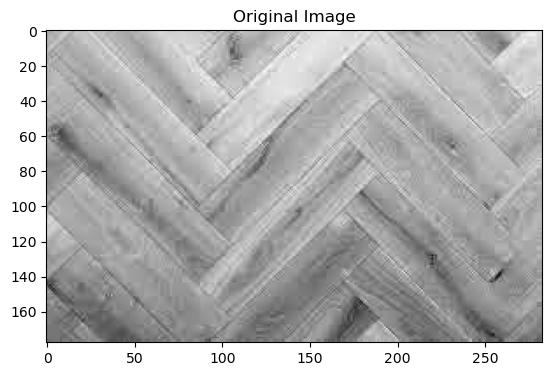

library has ntiles =  37846 each with npix =  900
row:
0
1
2
3
4
5
6
7
8
9


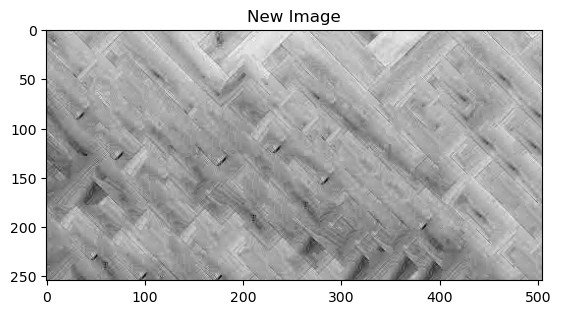

In [14]:
img = plt.imread("floor.jfif")
temp_img = (img[:,:,0]*0.299 + img[:,:,1]*0.587 + img[:,:,2]*0.114)
img = temp_img

plt.imshow(img, cmap = plt.cm.gray)
plt.title("Original Image")
plt.show()

output = quilt_demo(img)
plt.imshow(output, cmap = plt.cm.gray)
plt.title("New Image")
plt.show()

# Result 3

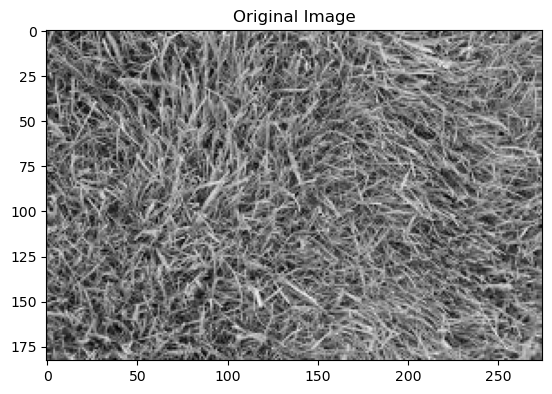

library has ntiles =  37884 each with npix =  900
row:
0
1
2
3
4
5
6
7
8
9


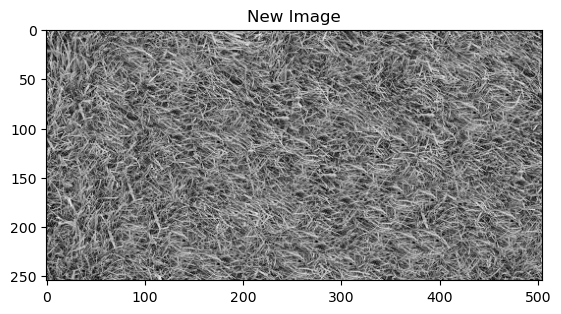

In [12]:
img = plt.imread("grass.jfif")
temp_img = (img[:,:,0]*0.299 + img[:,:,1]*0.587 + img[:,:,2]*0.114)
img = temp_img

plt.imshow(img, cmap = plt.cm.gray)
plt.title("Original Image")
plt.show()

output = quilt_demo(img)
plt.imshow(output, cmap = plt.cm.gray)
plt.title("New Image")
plt.show()